In [204]:
### Transformer is all you need

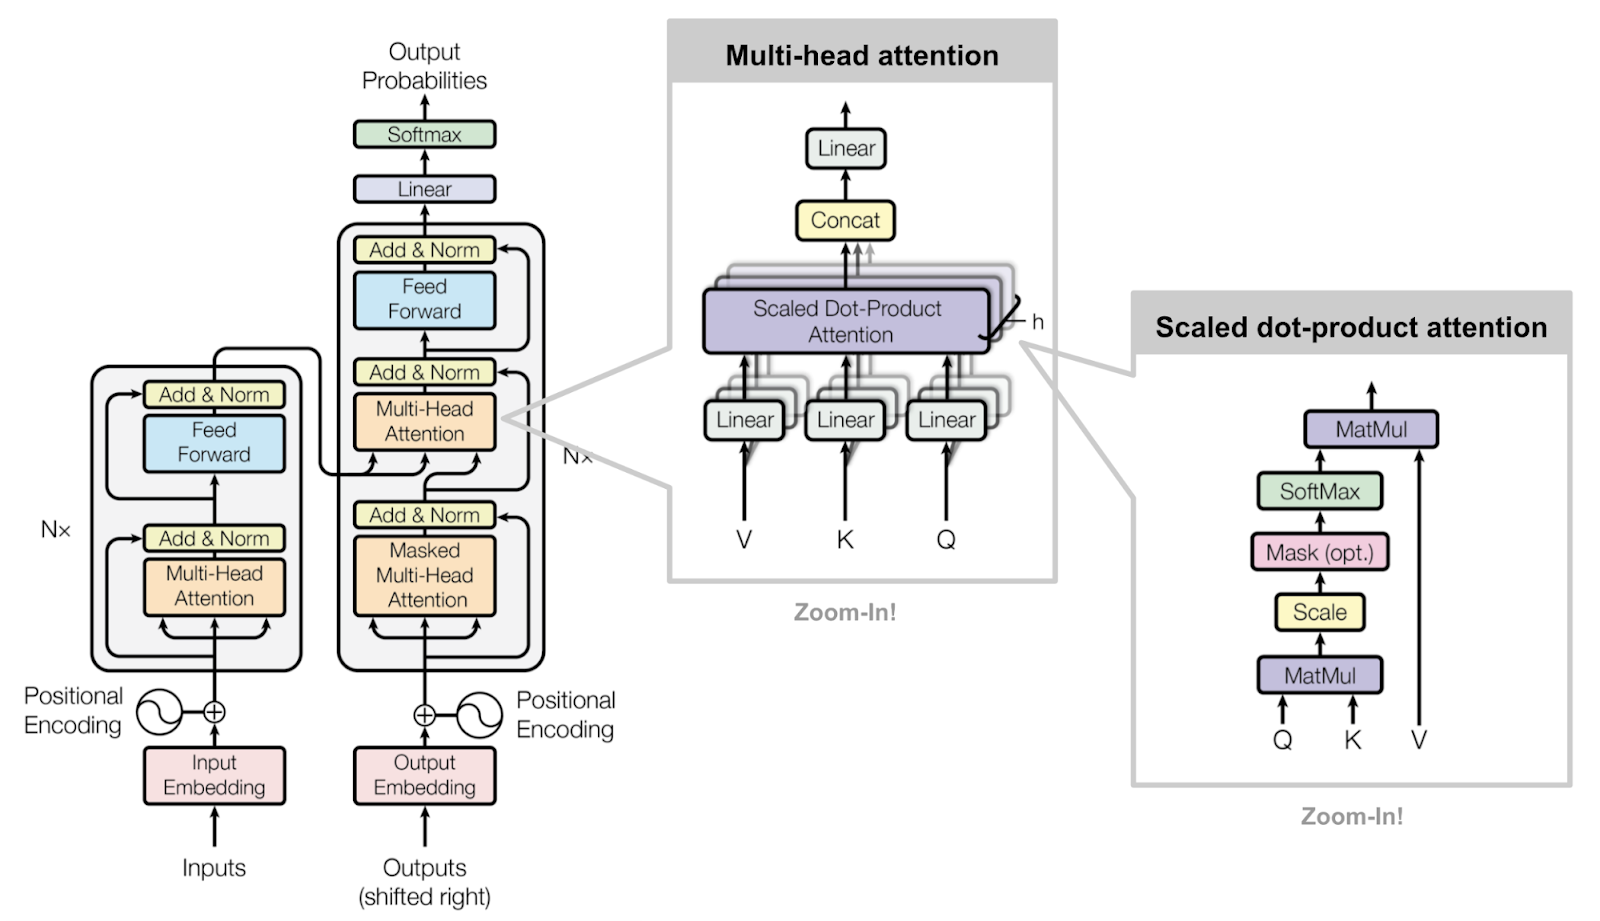

In [205]:
context_length = 8
embedding_dim = 12
vocab_size = 32000
padding_index = 2
input_text = "Share and Learn"

In [206]:
import torch
from torch import nn

In [207]:
# Tokenize
from src.tokenize.tokenizer import Tokenizer

TOKENIZER_CHECKPOINT = (
    "/home/pranav-pc/projects/OpenTransformer/multiformer/tokenizer_checkpoints/"
)
tokenizer = Tokenizer(TOKENIZER_CHECKPOINT)
print(tokenizer.encode(input_text, out_type=str))
tokenized_text = tokenizer.encode(input_text)
print(tokenized_text)

['<s>', '▁Share', '▁and', '▁Lear', 'n', '</s>']
[1, 26849, 322, 19530, 29876, 2]


In [208]:
tokenized_text = tokenized_text + [
    padding_index for _ in range(context_length - len(tokenized_text))
]
tokenized_text = torch.tensor(tokenized_text).view(1, -1)
tokenized_text

tensor([[    1, 26849,   322, 19530, 29876,     2,     2,     2]])

In [209]:
x = tokenized_text[:, :-1]
y = tokenized_text[:, 1:]
x, y

(tensor([[    1, 26849,   322, 19530, 29876,     2,     2]]),
 tensor([[26849,   322, 19530, 29876,     2,     2,     2]]))

In [210]:
# Link to benchmark test

In [211]:
embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_index)
x = embedding(tokenized_text)
x

tensor([[[ 0.9520, -0.8443, -0.6439, -0.9790,  0.1787, -0.9145,  0.1714,
          -0.9133, -0.4419,  0.4990, -1.6777,  0.1142],
         [-0.9753,  0.4457, -0.4584, -1.3325,  1.0739,  0.2585,  0.0385,
           2.0774, -0.2196, -1.2230, -0.6283,  0.9874],
         [-0.3678, -0.5272,  1.2875,  1.2428, -0.1570,  0.0063,  1.7316,
           0.4634, -0.4927, -1.4327, -0.4826,  1.0910],
         [ 1.5361, -0.2675, -0.1285,  1.6545, -0.4125,  0.6876, -0.2656,
           0.0701,  0.7832,  0.3624,  1.3612,  0.3861],
         [ 1.1215,  0.1205, -0.6238,  0.0702, -0.9418,  1.5262, -0.4417,
          -0.2812, -2.5594, -0.0077, -0.3546, -0.5734],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.00

In [212]:
pos_embedding = nn.Embedding(context_length, embedding_dim, padding_idx=padding_index)(
    torch.tensor(range(context_length))
)
pos_embedding

tensor([[-0.1606,  0.6267, -0.1962, -0.7793,  1.3902, -1.0661, -0.1456, -0.0637,
         -0.0320, -0.1851,  0.5410,  1.9691],
        [ 0.5991, -0.1860, -0.5993, -0.2494,  2.0495, -0.6305,  0.8618, -0.0326,
         -0.9248, -0.3645,  0.7848, -0.1755],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-1.1377, -0.2499,  0.8280, -0.9671, -0.9163,  0.0825,  0.7450, -0.2201,
          1.8875, -0.7761, -1.7042,  1.8092],
        [-3.7173,  0.1706,  0.2392,  0.0064,  1.0292, -0.7288, -1.4221, -0.1919,
         -0.7361,  2.2022,  0.5326,  0.2347],
        [ 0.4626,  1.7136, -1.3407,  0.0821,  0.5721, -0.5899,  0.3729, -0.4203,
         -1.9719, -0.0374, -0.4196,  0.2974],
        [ 1.2826, -0.6211,  0.4302, -0.2696,  0.2428,  0.3516, -0.1005, -0.2815,
          0.6466, -0.6111, -1.4201, -0.4054],
        [ 1.3911, -0.0228, -0.5493, -1.5776,  0.0598,  0.8451, -0.4481, -0.8019,
          0.8632, -1.2302,  1.

In [213]:
x += pos_embedding

In [214]:
from src.cells.normalization import LayerNorm

In [215]:
x = LayerNorm(ndim=embedding_dim, bias=True)(x)
x.shape
# refrence to the research paper

torch.Size([1, 8, 12])

In [ ]:
attn = nn.functional.scaled_dot_product_attention(
    x,
    x,
    x,
    attn_mask=None,
    dropout_p=0.0,
    is_causal=True,
)
attn.shape

torch.Size([1, 8, 12])

In [217]:
x += attn

In [219]:
x = LayerNorm(ndim=embedding_dim, bias=True)(x)
x.shape

torch.Size([1, 8, 12])

In [220]:
from src.cells.feedforward import FeedForward

In [221]:
x = FeedForward(d_model=embedding_dim, d_ff=2 * embedding_dim)(x)
x.shape

torch.Size([1, 8, 12])

In [222]:
out = nn.Linear(embedding_dim, vocab_size)
out.weight = embedding.weight

In [223]:
x = out(x)
x.shape

torch.Size([1, 8, 32000])

In [226]:
logits = nn.functional.softmax(x, dim=-1)
logits.shape

torch.Size([1, 8, 32000])

In [230]:
logits[:, -1, :]

tensor([[4.0043e-05, 5.6076e-05, 2.3525e-05,  ..., 3.4220e-05, 8.2890e-06,
         3.7272e-05]], grad_fn=<SliceBackward0>)

In [245]:
next_token = torch.multinomial(logits[:, -1, :], num_samples=1)
next_token

tensor([[26845]])

In [247]:
tokenizer.decode_ids(26845)

'computational'